# Simulating your own quantum device
Author: Boxi Li (etamin1201@gmail.com)

The noisy device simulator of QuTiP performs simulation of quantum circuit at the level of time evolution of an open quantum system (see [Noisy quantum device simulation with QuTiP](qip-noisy-device-simulator.ipynb) for details). In this notebook, we show how to define a custom quantum system under this framework. The notebook is divided into three parts:
1. Customizing the Hamiltonian model
2. Customizing the compiler
3. Customizing the noise

## Customizing the Hamiltonian model

We start from the customization of the Hamiltonian model of the quantum system. It is represented by the class `Processor`. To simulate a custom quantum device, we will build it as a subclass of `ModelProcessor`, which is used for simulators based on a concrete physics model (in contrast to optimal control for arbitrary Hamiltonians). In this way, we inherit the necessary methods from `ModelProcessor` used in the simulation. A minimal requirement for a processor model is specifying the hardware parameters and the Hamiltonian operators of the underlying physical system.

In the next cell, we show the definition of a custom `Processor` class as a whole block. In the following cells, we will then have a closer look at each part.

In [76]:
# imports
import numpy as np

from qutip import sigmax, sigmay, sigmaz, tensor, fidelity
from qutip import basis

from qutip_qip.pulse import Pulse
from qutip_qip.device import ModelProcessor
from qutip_qip.circuit import QubitCircuit
from qutip_qip.compiler import SpinChainCompiler
from qutip_qip.compiler import Instruction
from qutip_qip.compiler import GateCompiler
from qutip_qip.noise import Noise

import matplotlib.pyplot as plt

/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
class MyProcessor(ModelProcessor):
    """Custom processor built using ModelProcessor as the base class.
       This custom processor will inherit all the methods of the base class
       such as setting up of the T1 and T2 decoherence rates in the simulations.
       
       In addition, it is possible to write your own functions to add control pulses.
       
       Args:
           num_qubits (int): Number of qubits in the processor.
           t1, t2 (float or list): The T1 and T2 decoherence rates for the
    """
    def __init__(self, num_qubits, h_x, h_z, g, t1=None, t2=None):
        super(MyProcessor, self).__init__(num_qubits, t1=t1, t2=t2)  # call the parent class initializer
        self.pulse_mode = "discrete"  # The control pulse is discrete or continous.
        self.params = {"sz": [h_z] * num_qubits,  # can also be different for each qubit
                       "sx": [h_x] * num_qubits,
                       "g": [g] * num_qubits}
        self.dims = [2] * num_qubits  # The dimension of each controllable quantum system, here num_qubits qubits.
        self.num_qubits = num_qubits
        self.set_up_ops()  # set up the available Hamiltonians

    def set_up_ops(self):
        """Sets up the control operators.
        """
        for m in range(self.num_qubits):
            # sigmax pulse on m-th qubit with the corresponding pulse 
            self.add_control(2 * np.pi * sigmax(), m, label="sx" + str(m))
        # sz
        for m in range(self.num_qubits):
            self.add_control(2 * np.pi * sigmaz(), m, label="sz" + str(m))
        # interaction operator
        operator = tensor([sigmax(), sigmax()]) + tensor([sigmay(), sigmay()])
        for m in range(self.num_qubits - 1):
            self.add_control(2 * np.pi * operator, [m, m+1], label="g" + str(m))

/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


This is a quantum system of $n$ qubits arranged in a chain, where we have control over three Hamiltonian: $\sigma_x$, $\sigma_z$ on each qubit, and neighbouring-qubits interaction $\sigma_x\sigma_x+\sigma_y\sigma_y$:

$$
H = \sum_{j=0}^{n-1} c_{1,j}(t) \cdot h_x^{j}\sigma_x^{j} + \sum_{j=0}^{n-1} c_{2,j}(t) \cdot h_z^{j}\sigma_z^{j}
+ \sum_{j=0}^{n-2} c_{3,j}(t)\cdot g^{j}(\sigma_x^{j}\sigma_x^{j+1}+\sigma_y^{j}\sigma_y^{j+1})
$$

where $h_x$, $h_z$, $g$ are the hardware parameters and $c_{i,j}(t)$ are the time-dependent control pulse coefficients. This Hamiltonian is the same as the one for the linear spin chain model in QuTiP. In general, the hardware parameters will not be identical for each qubit, but here, for simplicity, we represent them by three numbers: $h_x$, $h_z$ and $g$.

We can initialize the processor class with these parameters:

In [51]:
num_qubits = 2
processor = MyProcessor(num_qubits, h_x=1.0, h_z=1.0, g=0.1)

/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In `set_up_ops`, we define the control Hamiltonians of the quantum system and use them to initialize the control pulses. We can get the map between the pulse labels and the pulse location with

In [52]:
processor.get_pulse_dict()

/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'sx0': 0, 'sx1': 1, 'sz0': 2, 'sz1': 3, 'g0': 4}

Or identify the control pulse by its label:

In [53]:
sx0_pulse = processor.find_pulse("sx0")
sx0_pulse.print_info()

----------------------------------------------------------------------
Pulse label: sx0
The pulse contains: 0 coherent noise elements and 0 Lindblad noise elements.

Ideal pulse:
{'qobj': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.         6.28318531]
 [6.28318531 0.        ]], 'targets': [0], 'tlist': None, 'coeff': None}
----------------------------------------------------------------------


/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Load and compile the circuit


We first define a quantum circuit for later use. Here we use a two-qubit circuit with two X  gates. Acting on a $|00\rangle$ state, this results in a $|11\rangle$ state.

/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


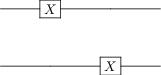

In [54]:
circuit = QubitCircuit(num_qubits)
circuit.add_gate("X", targets=1)
circuit.add_gate("X", targets=0)
circuit

For circuit plotting, see [this notebook](quantum-gates.ipynb).

To convert a quantum circuit into the Hamiltonian model, we need a compiler. The custom definition of a compiler will be discussed in details in the next section. Because we used the Hamiltonian model of the spin chain, we here simply "borrow" the compiler of the spin chain model.

In [55]:
processor = MyProcessor(num_qubits, h_x=1.0, h_z=1.0, g=0.1)
processor.native_gates = ["ISWAP", "RX", "RZ"]

compiler = SpinChainCompiler(processor.num_qubits, processor.params)

processor.load_circuit(circuit, compiler=compiler)
result = processor.run_state(init_state = basis([2,2], [0,0]))
result.states[-1]

/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.81484402+0.j        ]
 [ 0.        -0.38842325j]
 [ 0.        -0.38842325j]
 [-0.18515937+0.j        ]]

The compiled pulse coefficients are now saved in the processor and can be accessed by:

In [56]:
sx1_pulse = processor.find_pulse("sx1")
print(sx1_pulse.coeff)
print(sx1_pulse.tlist)

[1.]
[0.         1.57079633]


/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


This is a rectangular pulse that starts from time 0 and ends at time 0.25.

#### Note

For discrete pulse, the time sequence is one element shorter than the pulse coefficient because we need to specify the start and the end of the pulse. If two sequences are of the same length, the last element of `coeff` will be neglected. Later, we will see continuous pulse where `coeff` and `tlist` have the same length.

To give an intuitive illustration of the control pulses, we give each pulse a latex label by defining a method `get_operators_labels` and then plot the compiled pulses.

/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


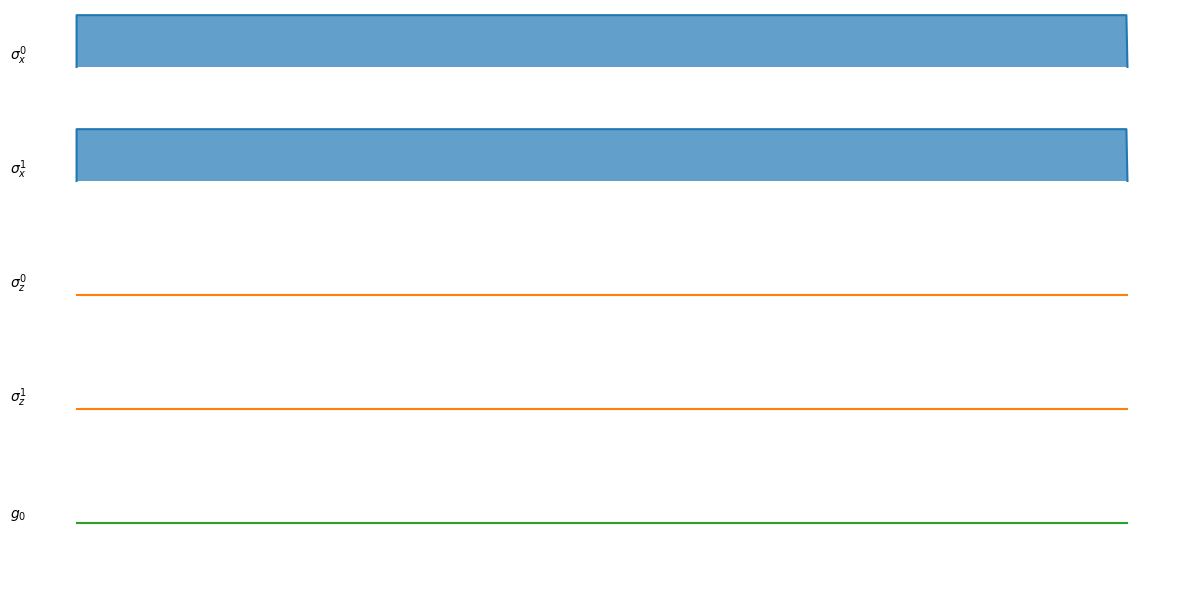

In [57]:
def get_operators_labels():
    """
    The function returns a 2-d nested list, in the plot,
    a different color will be used for each sublist.
    The total number of elements should match the number of control pulses.
    """
    return ([[r"$\sigma_x^%d$" % n for n in range(num_qubits)],
             [r"$\sigma_z^%d$" % n for n in range(num_qubits)],
             [r"$g_{%d}$" % (n) for n in range(num_qubits - 1)]])

processor.get_operators_labels = get_operators_labels
processor.plot_pulses()
plt.show()

## Customizing the compiler

How the quantum gates are implemented on hardware varies on different quantum systems. Even on the same physical platform, different implementation will yield different performance. The simplest way of implementation is to define a rectangular pulse like the one above. However, in reality, the control signal will have a continuous shape. In the following, we show how to customize the compiler with a gaussian pulse.

A typical gate compiler function looks like the one in the following cell, with the form ``XX_compiler(self, gate, args)``. It takes two arguments, `gate` and `args`: `gate` is the quantum gate to be compiled and `args` is a dictionary for additional parameters, for instance, parameters we defined in `Processor.params`.

For each gate, the function returns the input gate, the time sequence and the pulse coefficients in an `Instruction` object.

Below is an example of a rectangular pulse.

In [58]:
def rz_compiler(gate):
    """
    Compiles the RZ gate to an instruction for a pulse.

    Args:
        gate (qutip_qip.circuit.Gate): A qutip Gate object.

    Returns:
        Instruction (qutip_qip.compiler.instruction.Instruction): An instruction to implement
                                                                  a gate containing the control
                                                                  pulses.
    """
    tlist = np.array([1.])
    coeff = np.array([0., 0.25])
    # instruction is an object that includes the pulse coefficient and time sequence
    return [Instruction(gate, tlist, pulse_info)]

/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now we replace it with a Gaussian pulse. We define the Gaussian pulse in a way that the maximum matches the coupling strength $g$ and compute the $\sigma$ for the gaussian distribution from it. If you don't care about any parameters and just want to compile the gate to a fixed pulse sequence, you can also just define fixed `tlist` and `coeff` as two NumPy arrays.

In [60]:
def normalized_gauss_pulse():
    """
    Return a truncated and normalize Gaussian curve.
    The returned pulse is truncated from a Gaussian distribution with
    -3*sigma < t < 3*sigma.
    The amplitude is shifted so that the pulse start from 0.
    In addition, the pulse is normalized so that
    the total integral area is 1.
    """
    #  td normalization so that the total integral area is 1
    td = 2.4384880692912567
    sigma = 1/6 * td  # 3 sigma
    tlist = np.linspace(0, td, 100)
    max_pulse = 1 - np.exp(-(0-td/2)**2/2/sigma**2)
    coeff = (np.exp(-(tlist-td/2)**2/2/sigma**2)
        - np.exp(-(0-td/2)**2/2/sigma**2)) / max_pulse
    return tlist, coeff


def single_qubit_compiler(gate, args):
    """
    Compiler for the RX and RY gate.
    """
    targets = gate.targets
    if gate.name == "Y":
        pulse_prefix = "sy"
        pulse_strength = args["params"]["sy"][targets[0]]
    elif gate.name == "X":
        pulse_prefix = "sx"
        pulse_strength = args["params"]["sx"][targets[0]]
    tlist, coeff = normalized_gauss_pulse()
    sign = np.sign(pulse_strength)
    # rescale the tlist so that the total area is 1/4
    tlist = tlist / pulse_strength * sign / 4
    coeff = coeff * pulse_strength * sign
    pulse_info = [(pulse_prefix + str(targets[0]), coeff)]
    return [Instruction(gate, tlist, pulse_info)]



class MyCompiler(GateCompiler):  # compiler class
    def __init__(self, num_qubits, params):
        super(MyCompiler, self).__init__(num_qubits, params=params)
        # pass our compiler function as a compiler for X gate.
        self.gate_compiler["X"] = single_qubit_compiler
        self.gate_compiler["Y"] = single_qubit_compiler
        self.args.update({"params": params})

/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The attribute `pulse_mode` can be set to `"discrete"` or `"continuous"`. For continuous pulse, QuTiP solvers will use cubic spline interpolation. To minimize the boundary effect, it is recommended that the continuous pulse goes smoothly to 0 at the beginning and the end. We can see the advantage of the scheduling when we introduce a T1 decoherence and compare the fidelity of the final state.

In [61]:
gauss_compiler = MyCompiler(processor.num_qubits, processor.params)
processor = MyProcessor(num_qubits, h_x=1.0, h_z=1.0, g=0.1, t1=300)
processor.pulse_mode = "continuous"
tlist, coeff = processor.load_circuit(circuit, compiler=gauss_compiler, schedule_mode = False);
result = processor.run_state(init_state = basis([2,2], [0,0]))
print("fidelity without scheduling:", fidelity(result.states[-1], basis([2,2],[1,1])))

fidelity without scheduling: 0.9980899661770919


/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


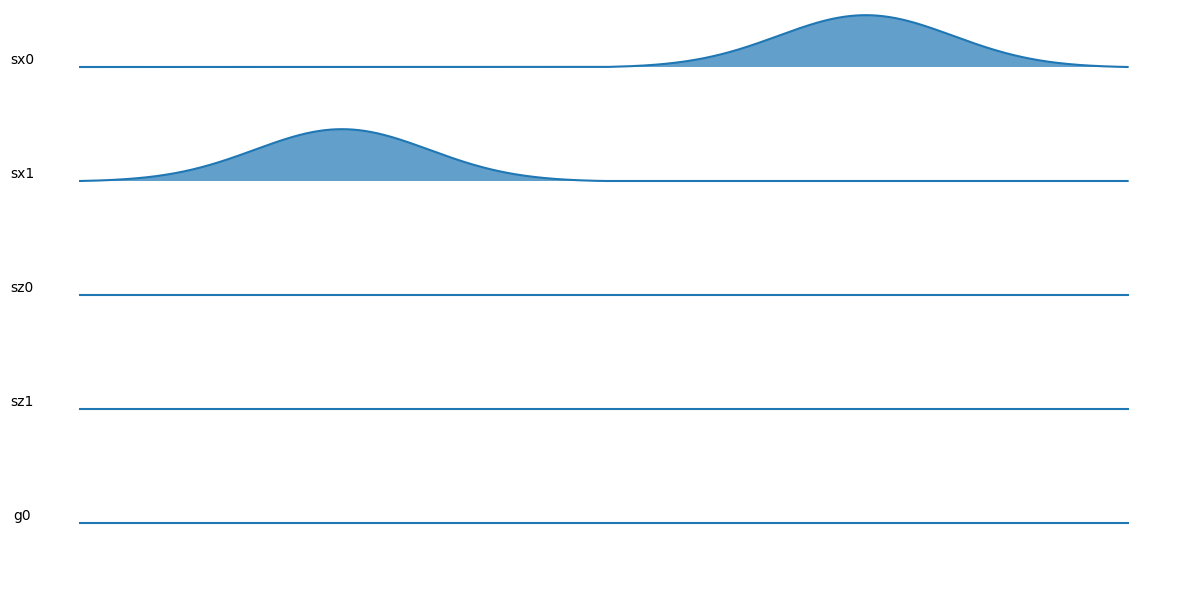

In [62]:
processor.plot_pulses()
plt.show()

We can also turn on the scheduler to schedule the circuit for a shorter execution time.

In [63]:
processor = MyProcessor(num_qubits, h_x=1.0, h_z=1.0, g=0.1, t1=300)
tlist, coeffs = processor.load_circuit(circuit, schedule_mode = "ASAP", compiler=gauss_compiler);
processor.pulse_mode = "continuous"
result = processor.run_state(init_state = basis([2,2], [0,0]))
print("fidelity with scheduling:", fidelity(result.states[-1], basis([2,2],[1,1])))

fidelity with scheduling: 0.9991048329620352


/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


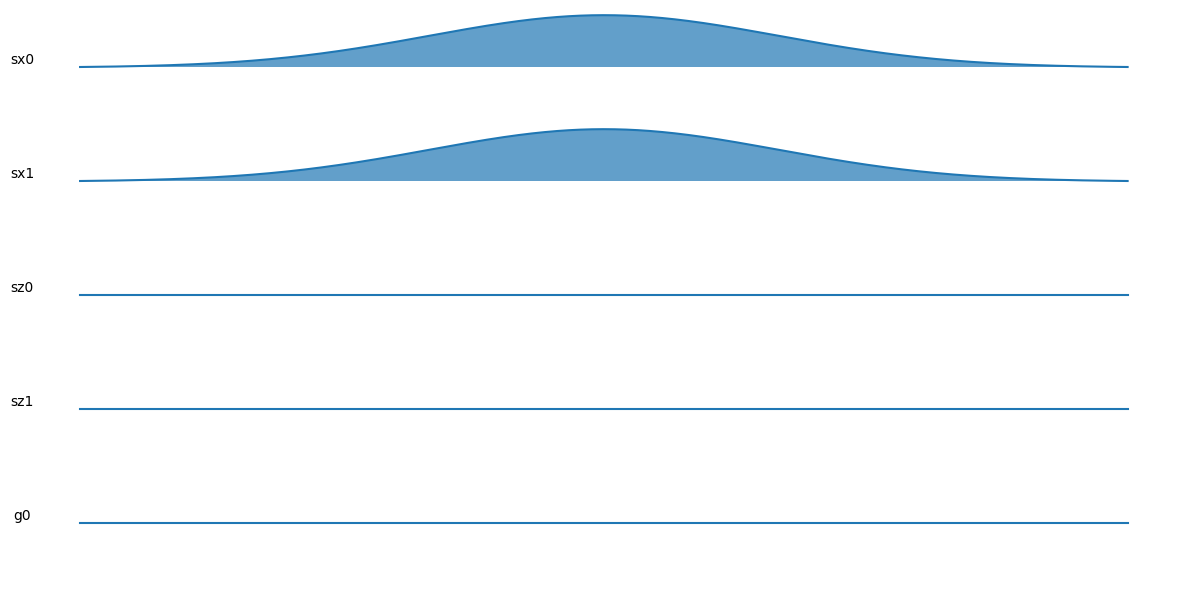

In [64]:
processor.plot_pulses()
plt.show()

### Define your own gate
The number of predefined gates in qutip is limited, hence you are encouraged to define your own gate. Here we show how to define a parametrized gate. First, you will need to define a gate function:

/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/shahnawaz/Dropbox/dev/qutip-qip/src/qutip_qip/circuit.py:274: UserWarning: Unknown gate MYGATE
  warnings.warn("Unknown gate %s" % name)


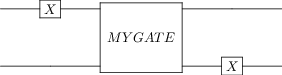

In [65]:
def mygate(theta = None):
    # We just call the Molmer Sorensen gate as an example.
    # If you do not want to run the circuit at the gate matrix level (circuit.run), no need for this function,
    # otherwise you will need to define this python function that returns the Qobj of the gate.)
    from qutip_qip.operations import molmer_sorensen
    return molmer_sorensen(theta, 2, targets=[0, 1])
circuit = QubitCircuit(2)
circuit.user_gates = {"MYGATE": mygate}  # no need for this if you don't use circuit.run
circuit.add_gate("X", targets=1)
circuit.add_gate("MYGATE", targets=[0,1], arg_value=3*np.pi/2)
circuit.add_gate("X", targets=0)
circuit
# You may see a warning because MYGATE is not found in defined LaTeX gate names, just ignore it.

In [66]:
circuit.run(basis([2,2],[0,0]))

/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        -0.70710678j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.70710678+0.j        ]]

The next step is to define a compiler function for it. Since compiling a real MS gate is rather complicated, we here just use a dummy triangular pulse. The goal is to show how to get access to the parameter `theta` during the compiling.

In [67]:
def mygate_compiler(gate, args):
    targets = gate.targets  # target qubit
    parameters = args["params"]
    
    theta = gate.arg_value
    coeff1 = np.concatenate([np.linspace(0,10,50), np.linspace(10,0,50), [0]]) / 50
    coeff2 = np.concatenate([np.linspace(0,10,50), np.linspace(10,0,50), [0]]) / 50
    pulse_info = [("sx" + str(targets[0]), theta * coeff1),
                  ("sx" + str(targets[1]), theta * coeff2)
                 ]  #  save the information in a tuple (pulse_name, coeff)
    tlist = np.linspace(0, 1, len(coeff1))
    return [Instruction(gate, tlist, pulse_info)]

/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


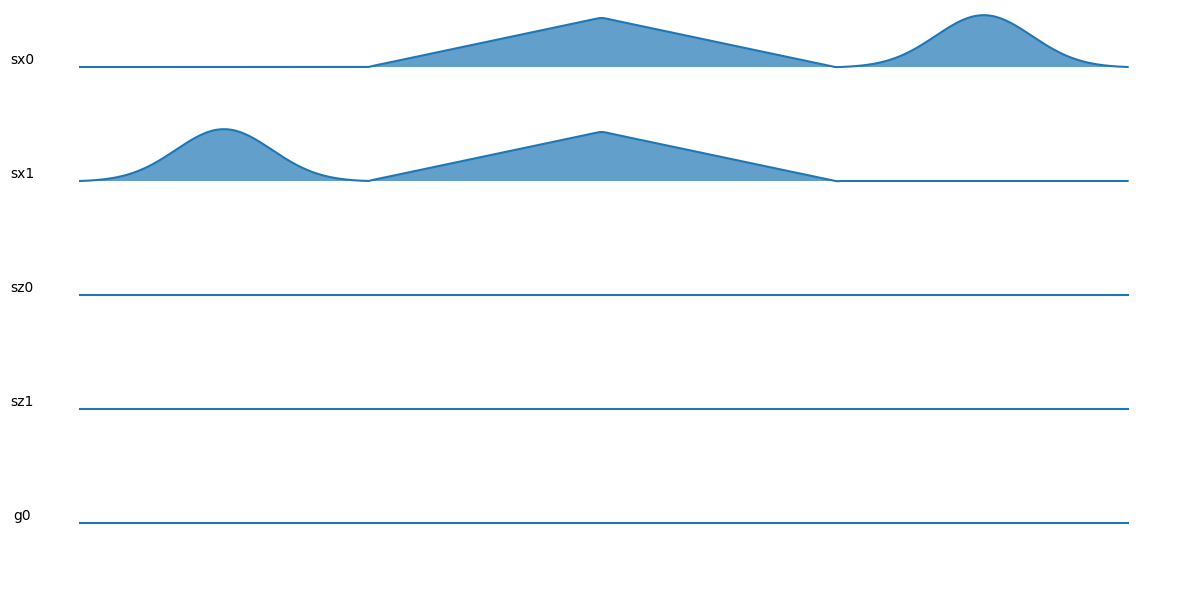

In [68]:
gauss_compiler = MyCompiler(processor.num_qubits, processor.params)
processor = MyProcessor(num_qubits, h_x=1.0, h_z=1.0, g=0.1, t1=300)
gauss_compiler.gate_compiler["MYGATE"] = mygate_compiler
processor.pulse_mode = "continuous"
tlist, coeff = processor.load_circuit(circuit, compiler=gauss_compiler)
processor.plot_pulses()
plt.show()

## Customizing the noise
Apart from pre-defined noise such as T1, T2 noise and random noise in the control pulse amplitude (see this [notebook](qip-noisy-device-simulator.ipynb), one can also define custom noise. Here we will see two examples of customizing noise, one systematic (pulse-independent) noise and one pulse-dependent noise. 

To understand how noise is processed, we briefly introduced the data structure of the simulation framework. The control elements are stored as a list of `Pulse` objects in the Processor. In each Pulse contains the idea pulse, the control noise part and the decoherence part. For systematic noise, it is saved under the `Pulse` representation labelled `"system"`, which represents the intrinsic dynamics of the quantum system. For pulse-dependent noise, we will add them to their corresponding control `Pulse`. 

The definition of noise is realized by a subclass of `UserNoise`, including two methods: 
- the initialization method containing the property of the noise, such as frequency or amplitude.
- the method `get_noisy_dynamics` that takes all the control pulse `pulses`, a dummy `Pulse` object representing systematic noise and the dimension of the system (here two qubits `[2,2]`).


In [69]:
class Extral_decay(Noise):
    def __init__(self, arg):
        self.arg = arg
        pass

    def get_noisy_dynamics(self, dims, pulses, systematic_noise):
        pass

/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Systematic noise

We first show an example of systematic noise. Here, we introduce a ZZ crosstalk noise between neighbouring qubits with a constant strength. It is done in three steps:

- Define the noise class.
- Initialize the noise object with given coupling strength.
- Define the Processor as usual and add the noise to the processor.

In the following example, we check the fidelity of the same circuit of two X gates, but now with this additional noise.

In [70]:
circuit = QubitCircuit(2)
circuit.add_gate("X", targets=1)
circuit.add_gate("X", targets=0)

/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
from qutip import sigmaz
from qutip_qip.operations import expand_operator
from qutip_qip.pulse import Pulse
from qutip_qip.noise import Noise

class ZZ_crosstalk(Noise):
    def __init__(self, strength):
        self.strength = strength

    def get_noisy_dynamics(self, dims, pulses, systematic_noise):
        zz_operator = tensor([sigmaz(), sigmaz()])
        for i in range(len(dims)-1):
            systematic_noise.add_control_noise(
                self.strength * zz_operator, targets=[i,i+1], tlist=None, coeff=True)  # constant, always 1

crosstalk_noise = ZZ_crosstalk(strength=1.0)

/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
processor = MyProcessor(num_qubits=2, h_x=1.0, h_z=1.0, g=0.1)
processor.add_noise(crosstalk_noise)  # The noise is added to the processor
gauss_compiler = MyCompiler(processor.num_qubits, processor.params)
tlist, coeff = processor.load_circuit(circuit, compiler=gauss_compiler);

result = processor.run_state(init_state = basis([2,2], [0,0]))
print("Final fidelity with ZZ crosstalk:", fidelity(result.states[-1],basis([2,2],[1,1])))

Final fidelity with ZZ crosstalk: 0.9896817791552549


/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Pulse dependent noise
In this second example, we demonstrate how to add an additional amplitude damping channel on the qubits. The amplitude of this decay is linearly dependent on the control pulse "sx", i.e. whenever the pulse "sx" is turned on, the decoherence is also turned on. The corresponding annihilation operator has a coefficient proportional to the control pulse amplitude. This noise can be added on top of the default T1, T2 noise.

In [73]:
from qutip_qip.pulse import Pulse
class Extral_decay(Noise):
    def __init__(self, ratio):
        self.ratio = ratio

    def get_noisy_dynamics(self, dims, pulses, systematic_noise):
        from qutip import destroy
        op = destroy(2)
        for pulse in pulses:   # iterate for all pulses
            if "sx" in pulse.label and pulse.coeff is not None:   # if it is a sigma-x pulse and is not empty
                pulse.add_lindblad_noise(op, targets=pulse.targets, tlist=pulse.tlist, coeff=self.ratio * pulse.coeff)
                # One can also use add_control_noise here to add addtional hamiltonian as noise (see next example).

extral_decay = Extral_decay(0.3)

/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
processor = MyProcessor(num_qubits, h_x=1.0, h_z=1.0, g=0.1)
processor.add_noise(extral_decay)
gauss_compiler = MyCompiler(processor.num_qubits, processor.params)
tlist, coeff = processor.load_circuit(circuit, compiler=gauss_compiler);

result = processor.run_state(init_state = basis([2,2], [0,0]))
print("Final fidelity with pulse dependent decoherence:", fidelity(result.states[-1],basis([2,2],[1,1])))

Final fidelity with pulse dependent decoherence: 0.9945081869193657


/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
from qutip.ipynbtools import version_table
version_table()

/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Software,Version
QuTiP,4.6.1
Numpy,1.19.2
SciPy,1.5.2
matplotlib,3.4.2
Cython,0.29.23
Number of CPUs,6
BLAS Info,Generic
IPython,7.23.1
Python,"3.7.6 | packaged by conda-forge | (default, Jan 7 2020, 22:05:27) [Clang 9.0.1 ]"
OS,posix [darwin]
